# Pizza Sales! 🍕

Welcome to our Pizza Sales Challenge, here you’ll be playing the role of a Data Analyst hired by Plato's Pizza, a Greek-inspired pizza place in New Jersey, to help the restaurant use data to improve operations. You've received the following note:

> Welcome aboard, we're so glad you're here to help!
> Things are going OK here at Plato's, but there's room for improvement. We've been collecting transactional data for the past year, but really haven't been able to put it to good use. Hoping you can analyze the data and put together a report to help us find opportunities to drive more sales and work more efficiently.

Plato's Pizza has historically been using Excel for their sales reporting needs, but want to see if there could be a more effective, scalable solution. They want to be able to monitor key business metrics such as: 

* What days and times do we tend to be busiest?
* How many pizzas are we making during peak periods?
* What are our best and worst-selling pizzas?
* What's our average order value?

Let's use Atoti to analyze Plato's Pizza sales, and address their operational needs.

## Import Libraries

First off, let's import the necessary libraries.

In [10]:
import atoti
import pandas as pd

## Instantiate Atoti Server and UI

Now, we'll spin up the Atoti server and link the session to our web-based Atoti UI.

**💡 Note:**  https://docs.atoti.io/latest/api/atoti.Session.html#atoti.Session

In [ ]:
# Start an Atoti Server instance
session = atoti.Session(
    user_content_storage="./content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"],
)
session.link

Closing existing "Unnamed" session to create the new one.


## Inspect Data Quality Using Pandas

Next, let's load up Pandas to quickly take a look at our data, inspect it's quality, and make quick formatting changes if need be.

In [ ]:
# Read CSV into Pandas DataFrame
pizza_sales_df = pd.read_csv("data/pizza_sales.csv")
pizza_sales_df.head()

Nice, looks like we're working with some pretty intact data.

In [8]:
# Check null counts for each column
pizza_sales_df.isnull().sum(axis=0)

order_details_id     0
order_id             0
pizza_id             0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

Let's take a look at the data types of our columns.

In [9]:
# Check column data types
pizza_sales_df.dtypes

order_details_id       int64
order_id               int64
pizza_id              object
quantity               int64
order_date            object
order_time            object
unit_price           float64
total_price          float64
pizza_size            object
pizza_category        object
pizza_ingredients     object
pizza_name            object
dtype: object

## Format Data in Pandas

In [6]:
# Convert string to datetime and set day of the week (e.g. Monday=0, Sunday=6)
pizza_sales_df["order_date"] = pd.to_datetime(
    pizza_sales_df["order_date"], format="mixed"
)
pizza_sales_df["dayofweek"] = pizza_sales_df["order_date"].dt.dayofweek

# Cast as string data types and view modified DataFrame
pizza_sales_df["order_details_id"] = pizza_sales_df["order_details_id"].astype(str)
pizza_sales_df["order_id"] = pizza_sales_df["order_id"].astype(str)
pizza_sales_df["dayofweek"] = pizza_sales_df["dayofweek"].astype(str)
pizza_sales_df.head()

,order_details_id,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,dayofweek
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,3
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,3
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,3
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,3
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,3


In [7]:
# Check new column data types
pizza_sales_df.dtypes

order_details_id             object
order_id                     object
pizza_id                     object
quantity                      int64
order_date           datetime64[ns]
order_time                   object
unit_price                  float64
total_price                 float64
pizza_size                   object
pizza_category               object
pizza_ingredients            object
pizza_name                   object
dayofweek                    object
dtype: object

## Load Pandas DataFrame Into Atoti Cube

In [8]:
# Load Pandas DataFrame as Atoti Table object
pizza_sales_table = session.read_pandas(
    pizza_sales_df, table_name="pizza_sales_table", keys=["order_details_id"]
)
pizza_sales_table.head()

,order_id,pizza_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,dayofweek
order_details_id,,,,,,,,,,,,
13,7,spinach_supr_s,1,2015-01-01,12:50:37,12.5,12.5,S,Supreme,"Spinach, Red Onions, Pepperoni, Tomatoes, Arti...",The Spinach Supreme Pizza,3
27,11,cali_ckn_l,1,2015-01-01,13:02:59,20.75,20.75,L,Chicken,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",The California Chicken Pizza,3
41,16,napolitana_s,1,2015-01-01,13:34:07,12.0,12.0,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza,3
55,19,sicilian_l,1,2015-01-01,13:59:09,20.25,20.25,L,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza,3
69,26,classic_dlx_s,1,2015-01-01,14:54:26,12.0,12.0,S,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,3


In [9]:
# Create Cube from Atoti Table object
cube = session.create_cube(pizza_sales_table)

## Cube Data Model Analysis

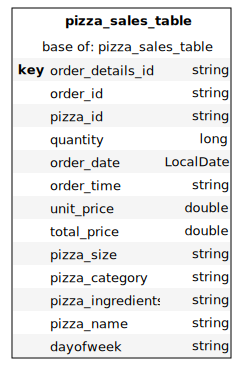

In [10]:
# View the schema
session.tables.schema

In [11]:
# Set variables for hierarchies, levels, and measures
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [12]:
# View hierarchies for the cube
cube.create_date_hierarchy("multi-level time", column=pizza_sales_table["order_date"])
h

{('pizza_sales_table', 'dayofweek'): <atoti.hierarchy.Hierarchy object at 0x14e5f2590>, ('pizza_sales_table', 'pizza_id'): <atoti.hierarchy.Hierarchy object at 0x14e5f25f0>, ('pizza_sales_table', 'pizza_name'): <atoti.hierarchy.Hierarchy object at 0x14e5f26e0>, ('pizza_sales_table', 'pizza_ingredients'): <atoti.hierarchy.Hierarchy object at 0x14e5f27d0>, ('pizza_sales_table', 'order_id'): <atoti.hierarchy.Hierarchy object at 0x14e5f28c0>, ('pizza_sales_table', 'order_date'): <atoti.hierarchy.Hierarchy object at 0x14e5f29b0>, ('pizza_sales_table', 'multi-level time'): <atoti.hierarchy.Hierarchy object at 0x14e5f2aa0>, ('pizza_sales_table', 'order_details_id'): <atoti.hierarchy.Hierarchy object at 0x14e5f2b90>, ('pizza_sales_table', 'pizza_category'): <atoti.hierarchy.Hierarchy object at 0x14e5f2e00>, ('pizza_sales_table', 'order_time'): <atoti.hierarchy.Hierarchy object at 0x14e5f2ef0>, ('pizza_sales_table', 'pizza_size'): <atoti.hierarchy.Hierarchy object at 0x14e5f2fe0>}

In [13]:
# View levels for the cube
l

In [14]:
# View measures for the cube
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x14f917e50>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x14e5f01c0>, 'order_date_auto_y.MEAN': <atoti.measure.Measure object at 0x14e5f2980>, 'order_date_auto_y.SUM': <atoti.measure.Measure object at 0x14e5f0820>, 'unit_price.MEAN': <atoti.measure.Measure object at 0x14e5f3ac0>, 'unit_price.SUM': <atoti.measure.Measure object at 0x14e5f0bb0>, 'order_date_auto_M.MEAN': <atoti.measure.Measure object at 0x14e5f3400>, 'order_date_auto_M.SUM': <atoti.measure.Measure object at 0x14e5f0d60>, 'order_date_auto_d.MEAN': <atoti.measure.Measure object at 0x14e5f1d50>, 'order_date_auto_d.SUM': <atoti.measure.Measure object at 0x14e5f2d10>, 'quantity.MEAN': <atoti.measure.Measure object at 0x14e5f3910>, 'quantity.SUM': <atoti.measure.Measure object at 0x14e5f0160>, 'total_price.MEAN': <atoti.measure.Measure object at 0x14e5f2200>, 'total_price.SUM': <atoti.measure.Measure object at 0x14e5f03d0>}

In [15]:
# Clean up extraneous measures
del m["order_date_auto_M.MEAN"]
del m["order_date_auto_d.MEAN"]
del m["order_date_auto_y.MEAN"]
del m["order_date_auto_M.SUM"]
del m["order_date_auto_d.SUM"]
del m["order_date_auto_y.SUM"]
m

{'contributors.COUNT': <atoti.measure.Measure object at 0x14e5f2680>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x14e5f22f0>, 'unit_price.MEAN': <atoti.measure.Measure object at 0x14e5f2440>, 'unit_price.SUM': <atoti.measure.Measure object at 0x14e5f2b00>, 'quantity.MEAN': <atoti.measure.Measure object at 0x14e5f1d80>, 'quantity.SUM': <atoti.measure.Measure object at 0x14e5f3880>, 'total_price.MEAN': <atoti.measure.Measure object at 0x14e5f13c0>, 'total_price.SUM': <atoti.measure.Measure object at 0x14e5f0d60>}

## Data Analysis and Visualization in Atoti

* What days and times do we tend to be busiest?
* How many pizzas are we making during peak periods?
* What are our best and worst-selling pizzas?
* What's our average order value?

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
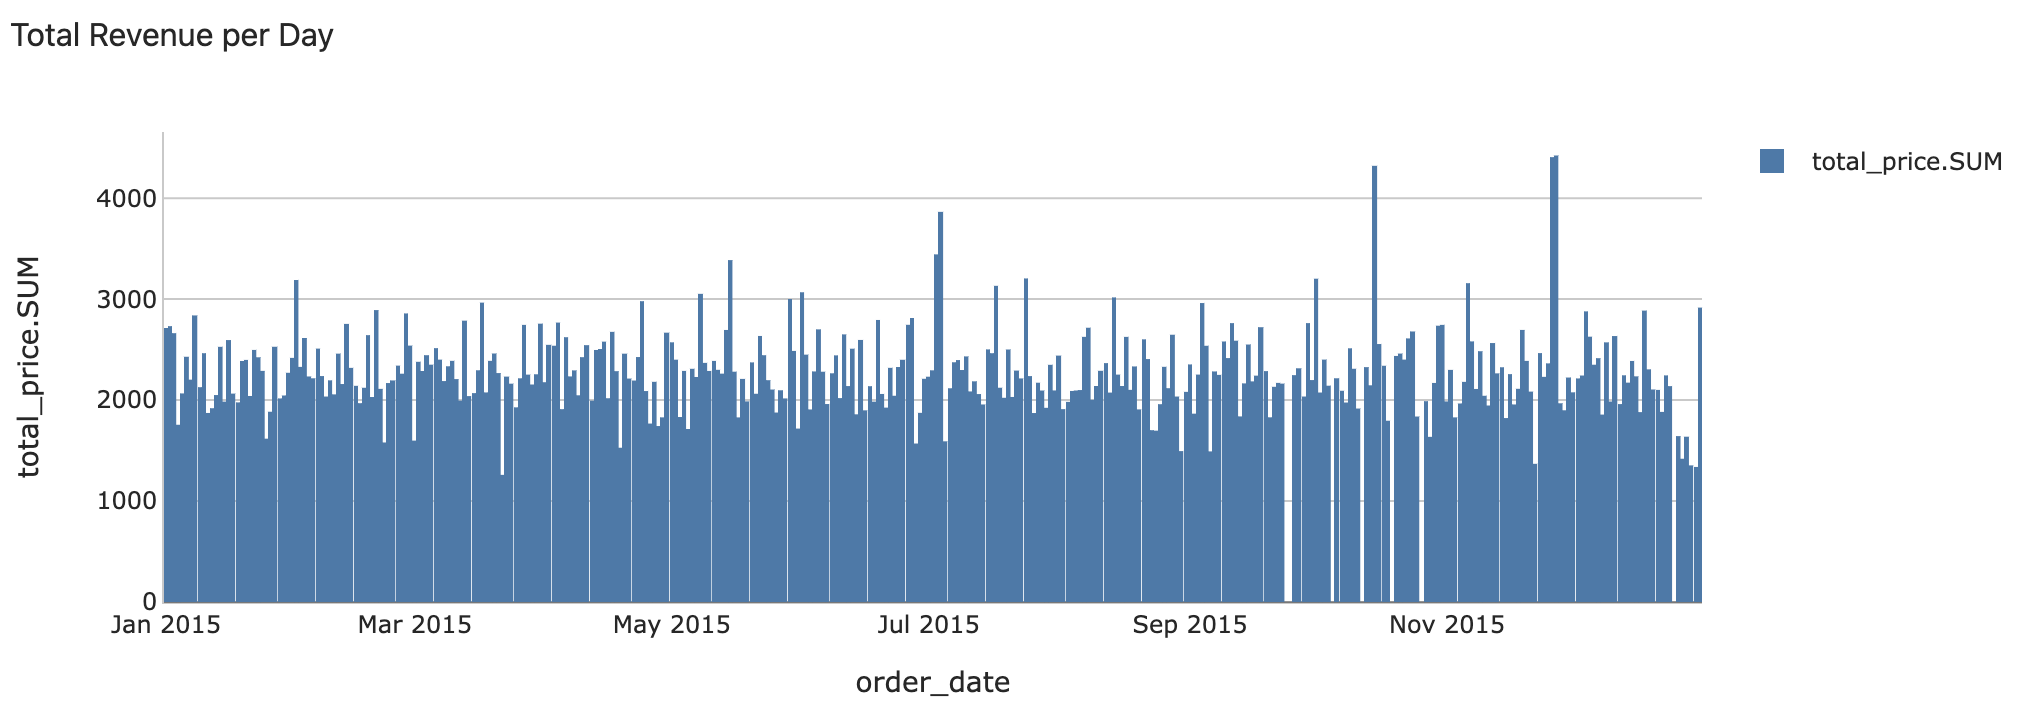

In [16]:
# Set x-axis as order_date, y-axis as total_price.SUM
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
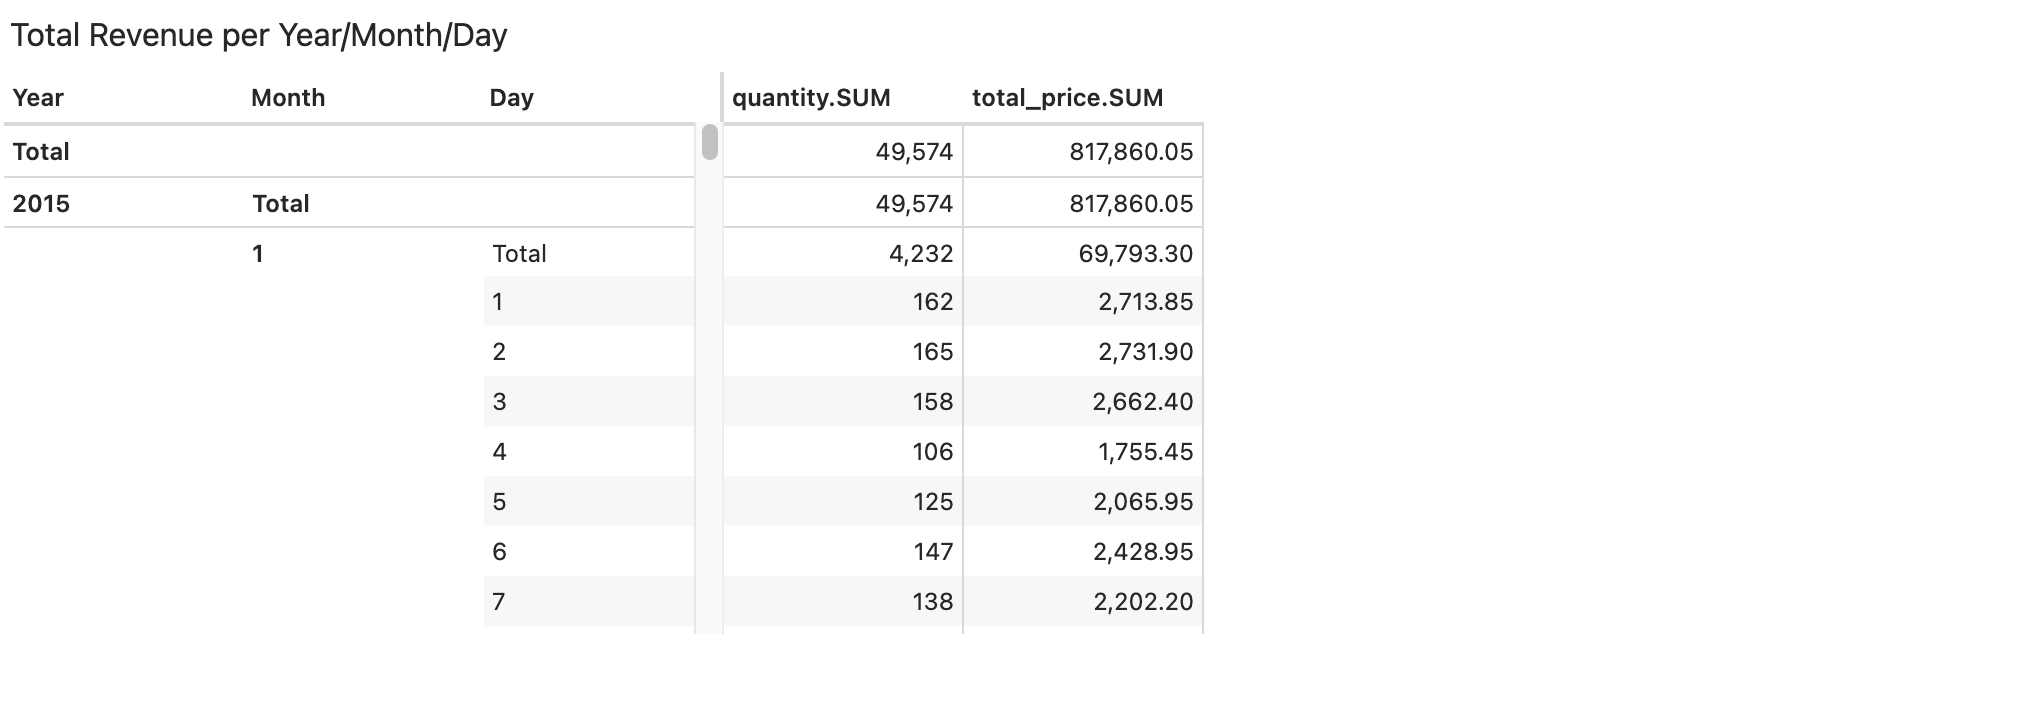

In [17]:
# Set x-axis as multi-level date hierarchy, y-axis as total_price.SUM
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
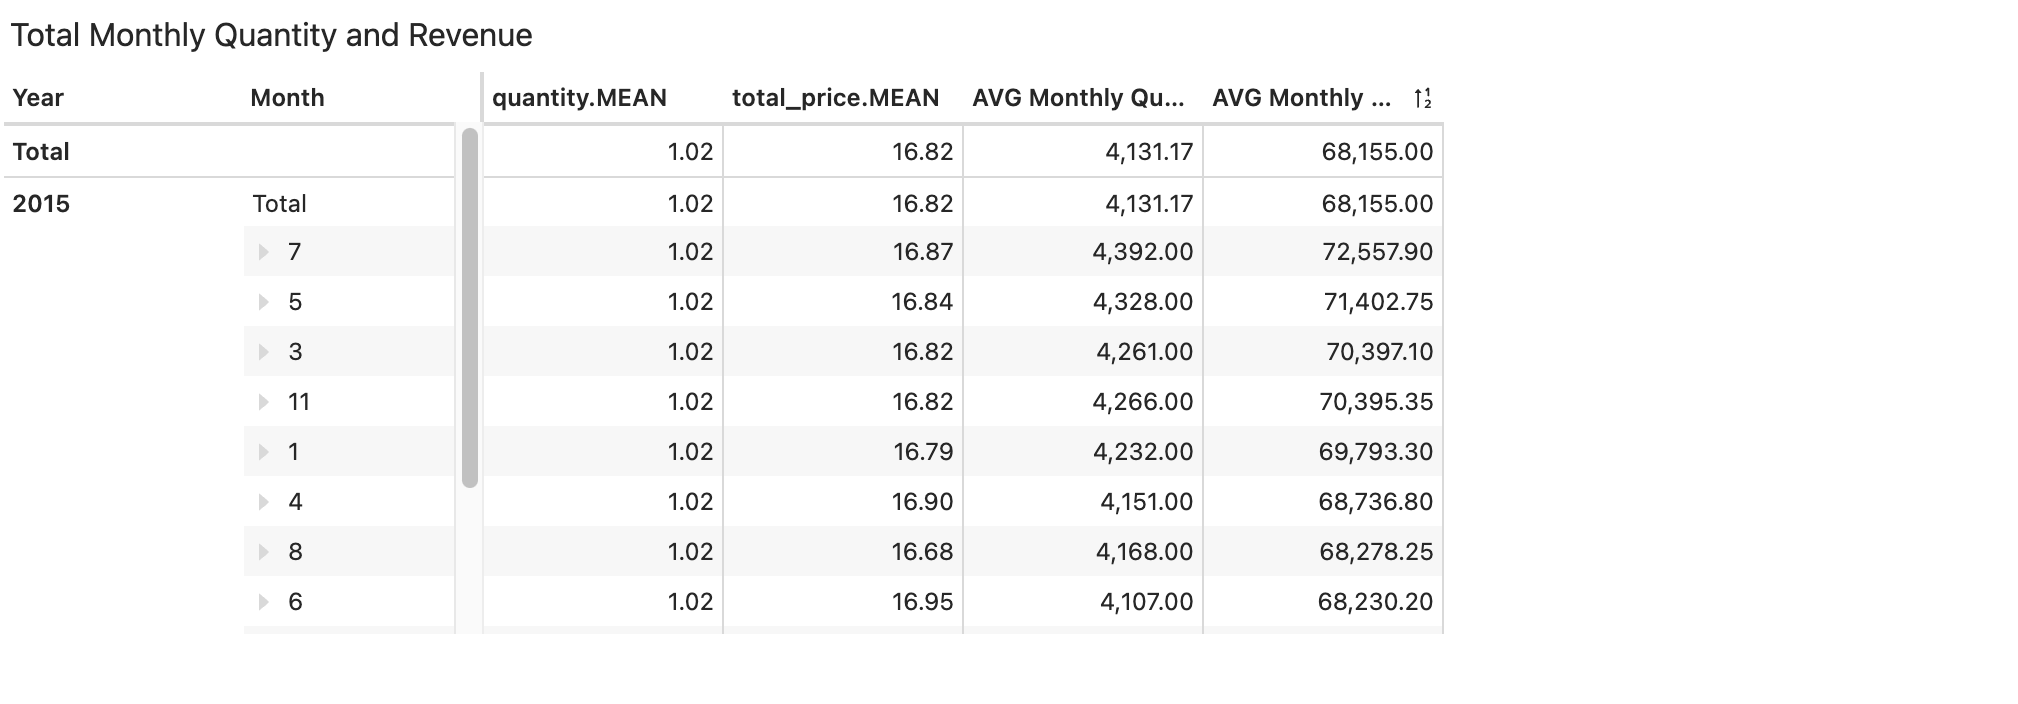

In [18]:
# Calculate correct average monthly quantity and mean, wrt to month level
m["AVG Monthly Quantity"] = atoti.agg.mean(
    m["quantity.SUM"], scope=atoti.OriginScope(l["Month"])
)
m["AVG Monthly Revenue"] = atoti.agg.mean(
    m["total_price.SUM"], scope=atoti.OriginScope(l["Month"])
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
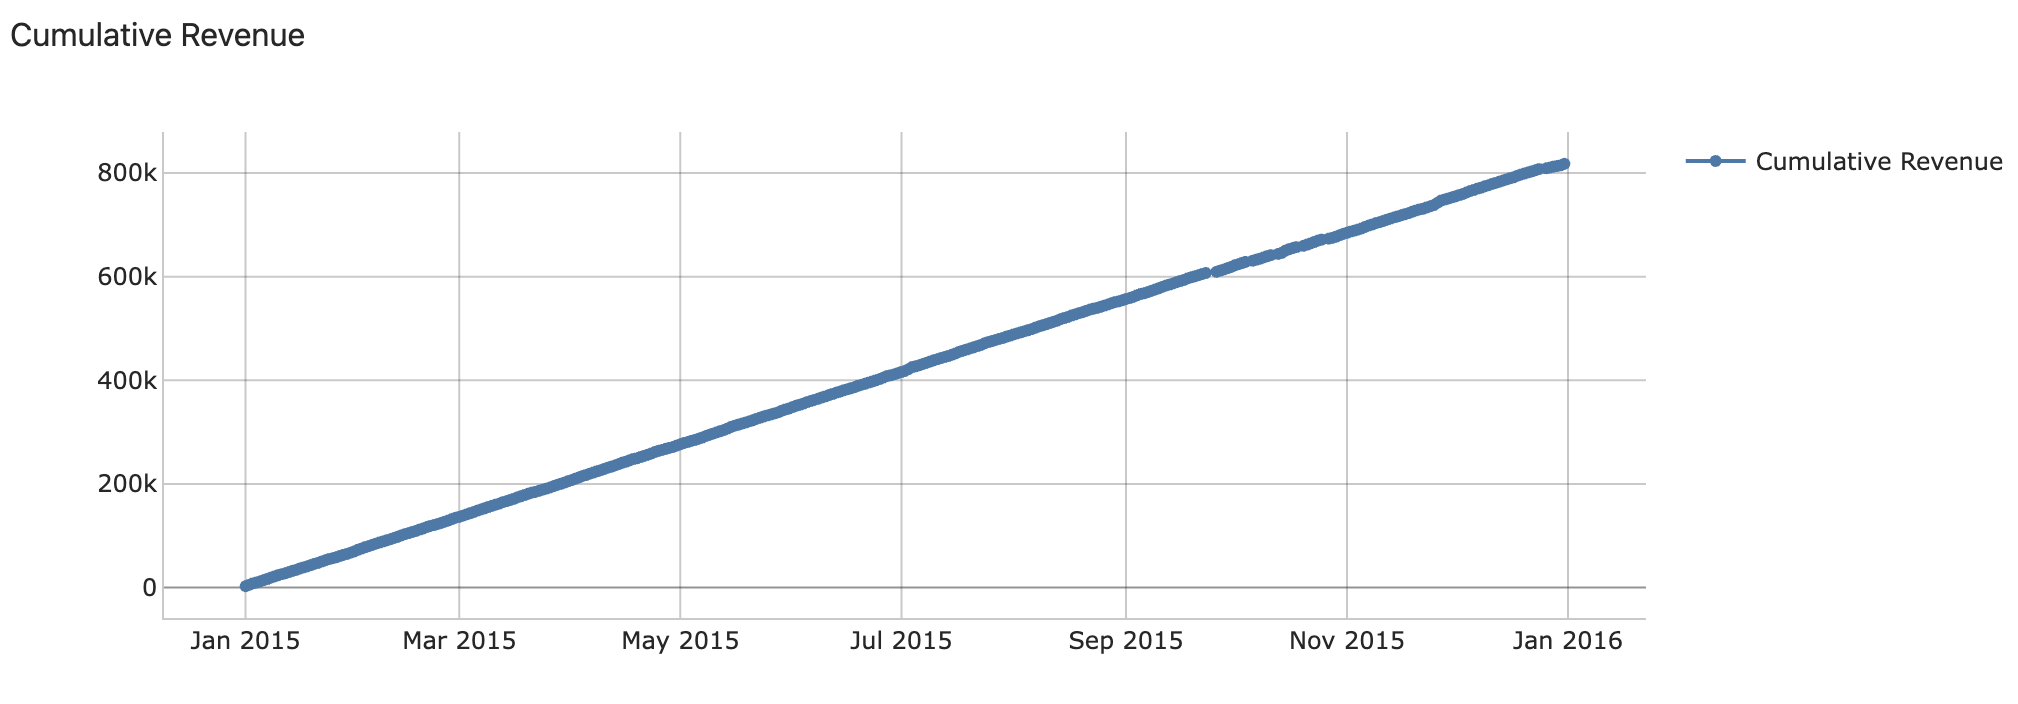

In [19]:
# Calculate cumulative daily revenue
m["Cumulative Revenue"] = atoti.agg.sum(
    m["total_price.SUM"], scope=atoti.CumulativeScope(level=l["order_date"])
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
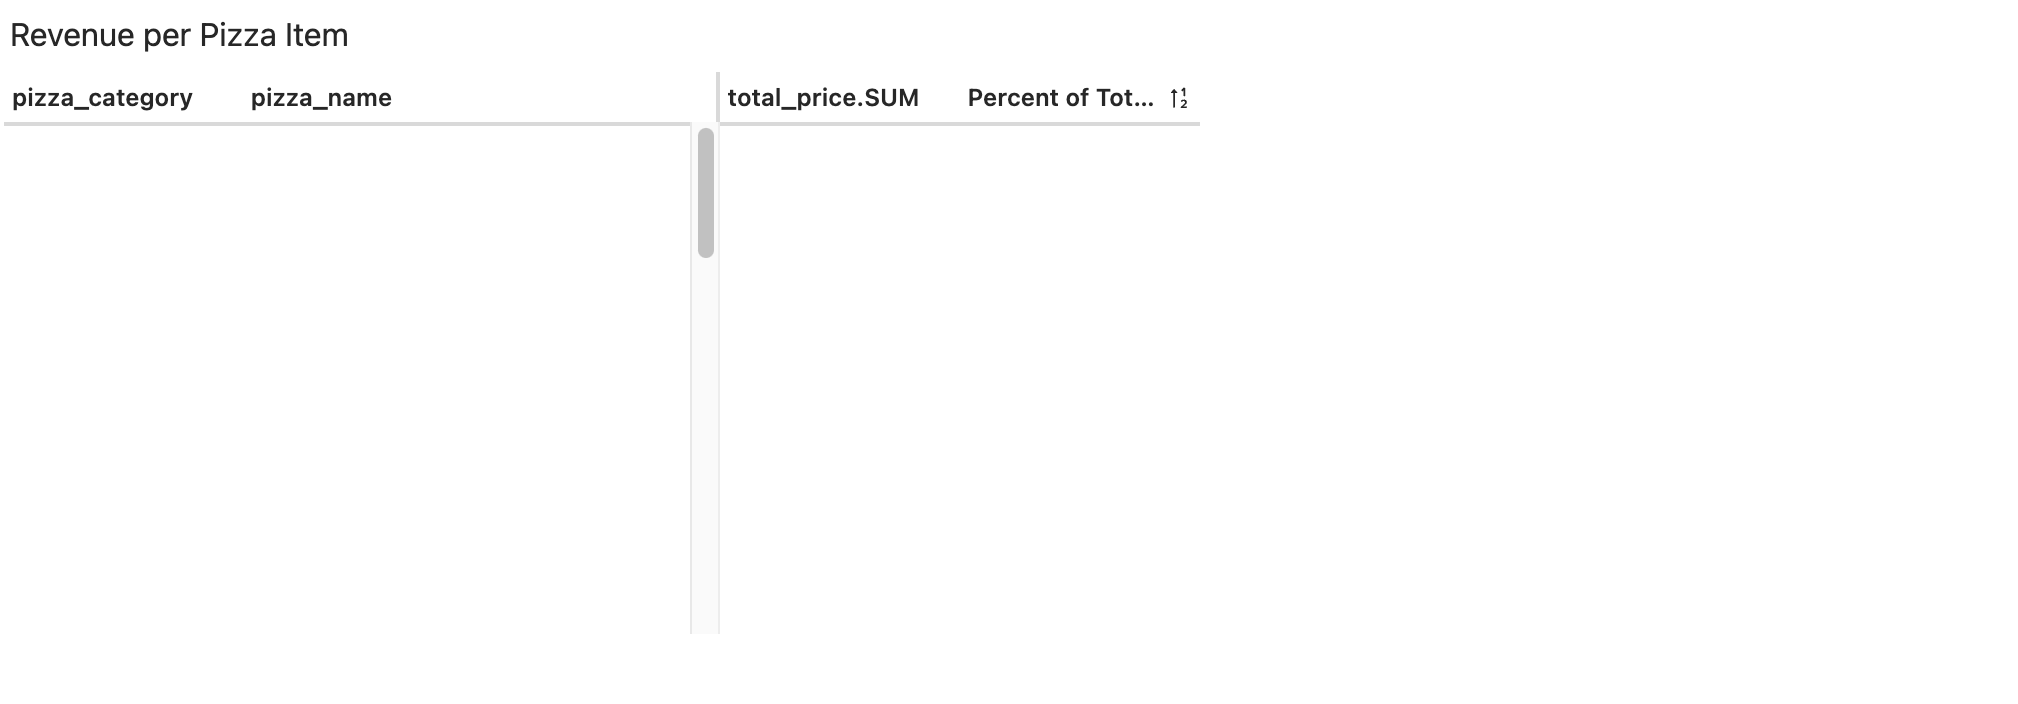

In [20]:
# Calculate percent of total revenue by pizza item (incorrect)
m["Percent of Total Revenue"] = m["total_price.SUM"] / atoti.total(
    m["total_price.SUM"], h["pizza_category"]
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
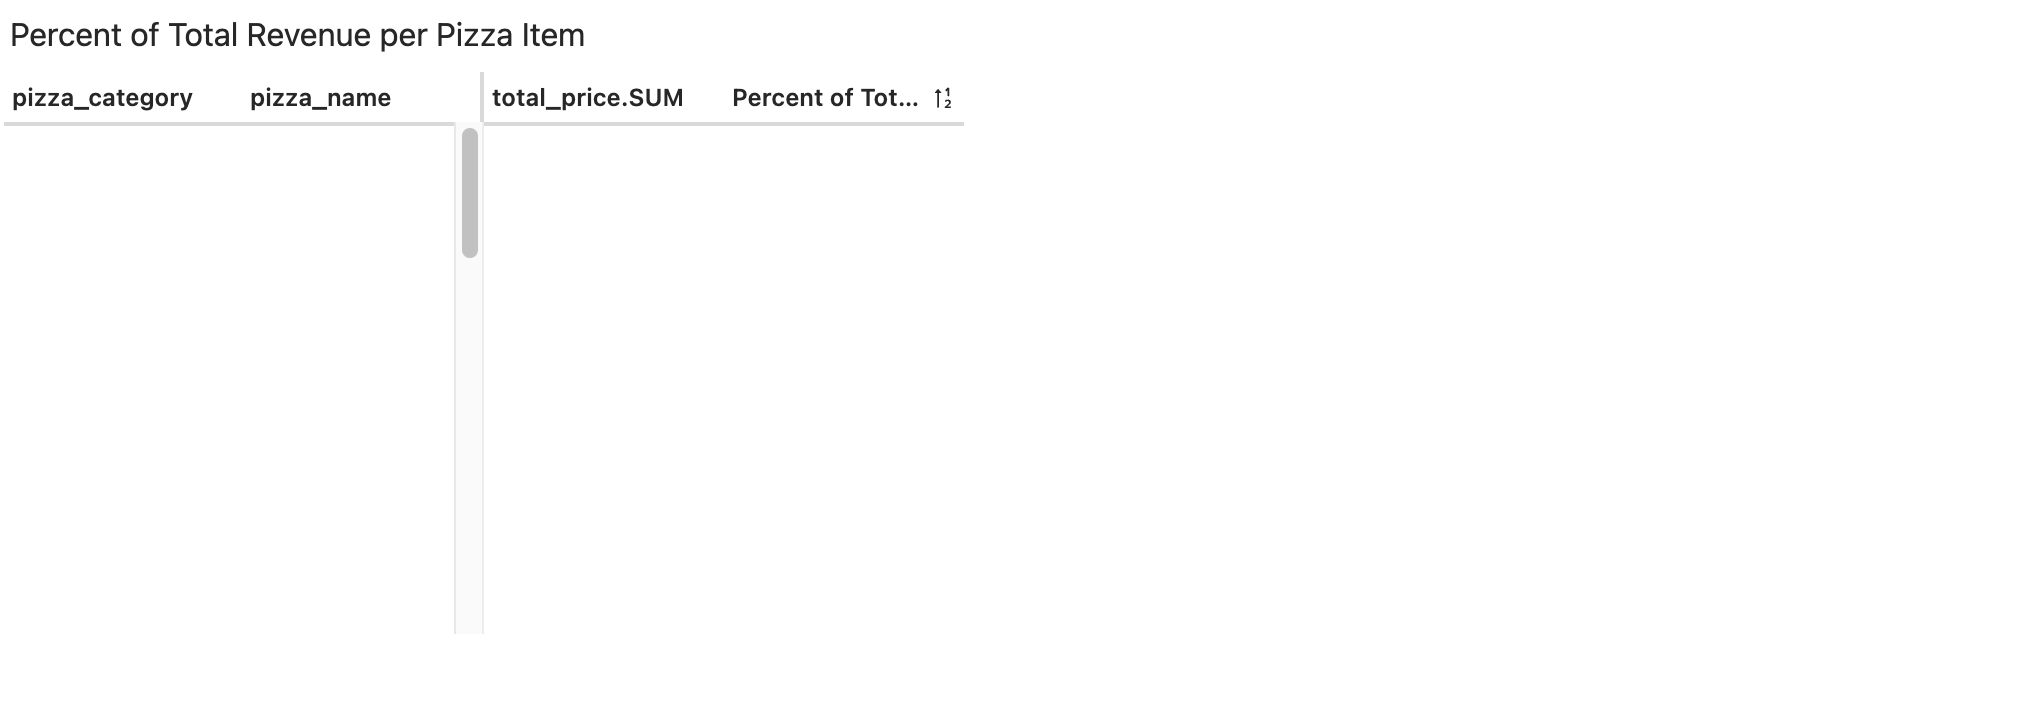

In [21]:
# Calculate percent of total revenue by pizza item (correct)
m["Percent of Total Revenue"] = m["total_price.SUM"] / atoti.total(
    m["total_price.SUM"], h["pizza_category"], h["pizza_name"]
)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
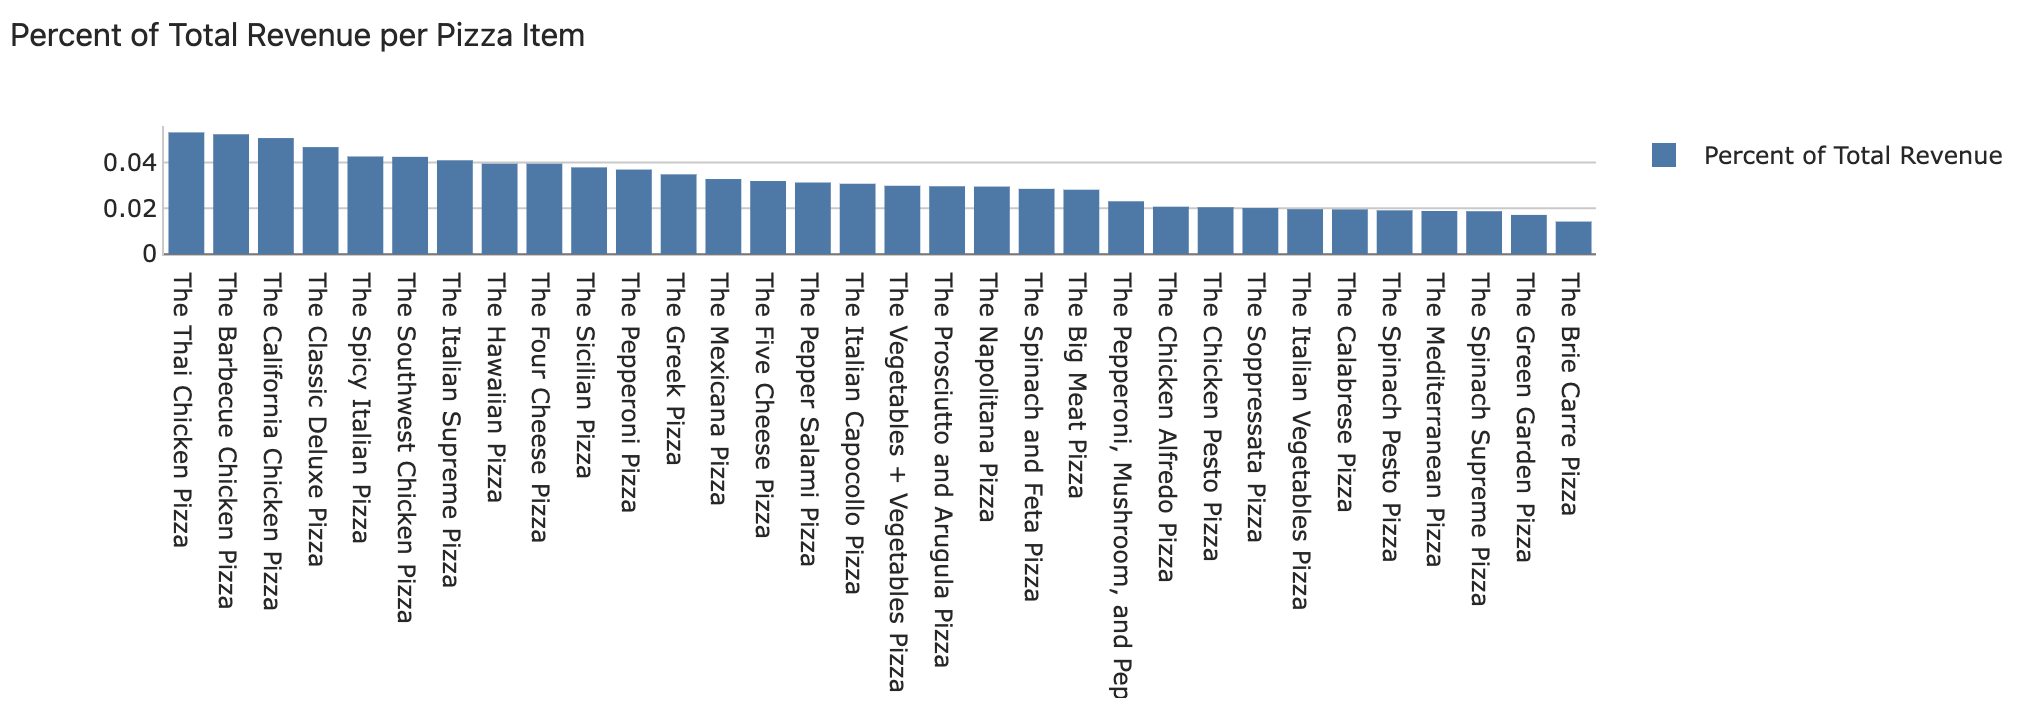

In [22]:
# Visualize percent of total revenue by pizza item
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
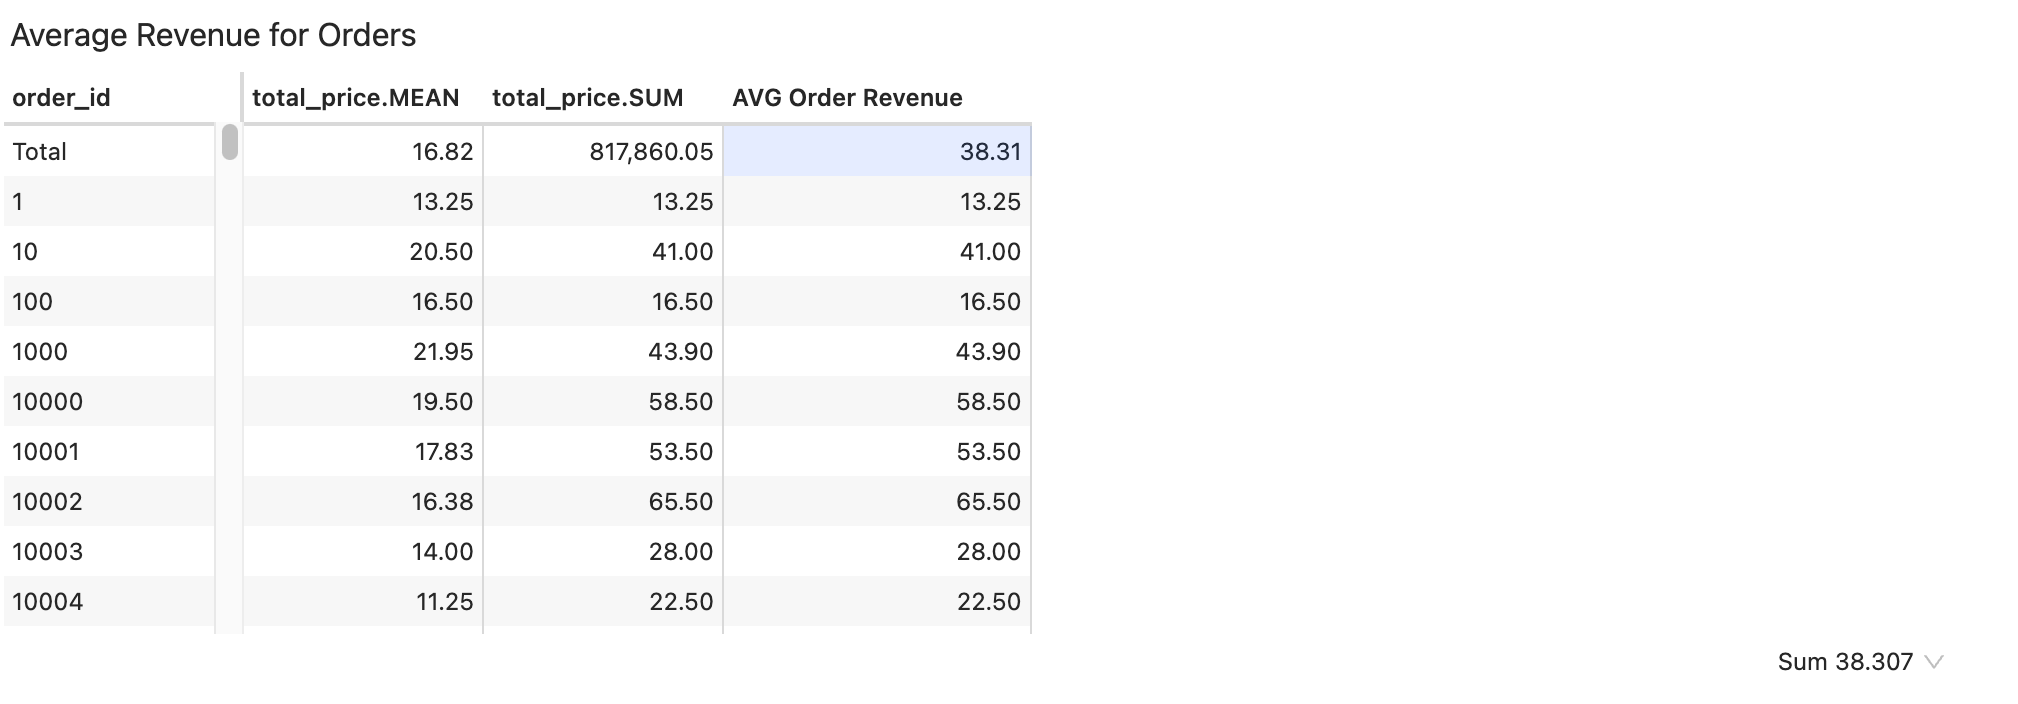

In [23]:
# Calculate average revenue per order
m["AVG Order Revenue"] = atoti.agg.mean(
    m["total_price.SUM"], scope=atoti.OriginScope(l["order_id"])
)
session.widget